## **Sitzung 8 - K-Nearest Neighbor in Python**

---

**Einführung**

Um zu veranschaulichen, wie Python die Distanz zwischen zwei Punkten - also die Grundlage für die Identifikation der Nachbarpunkte - berechnet, erstellen wir zwei Vektoren (arrays), die den grünen und den blauen Punkt in der Abbildung repräsentieren. Anschließend berechnen wir die Distanz zwischen beiden Punkten mithilfe des Satz des Pythagoras.

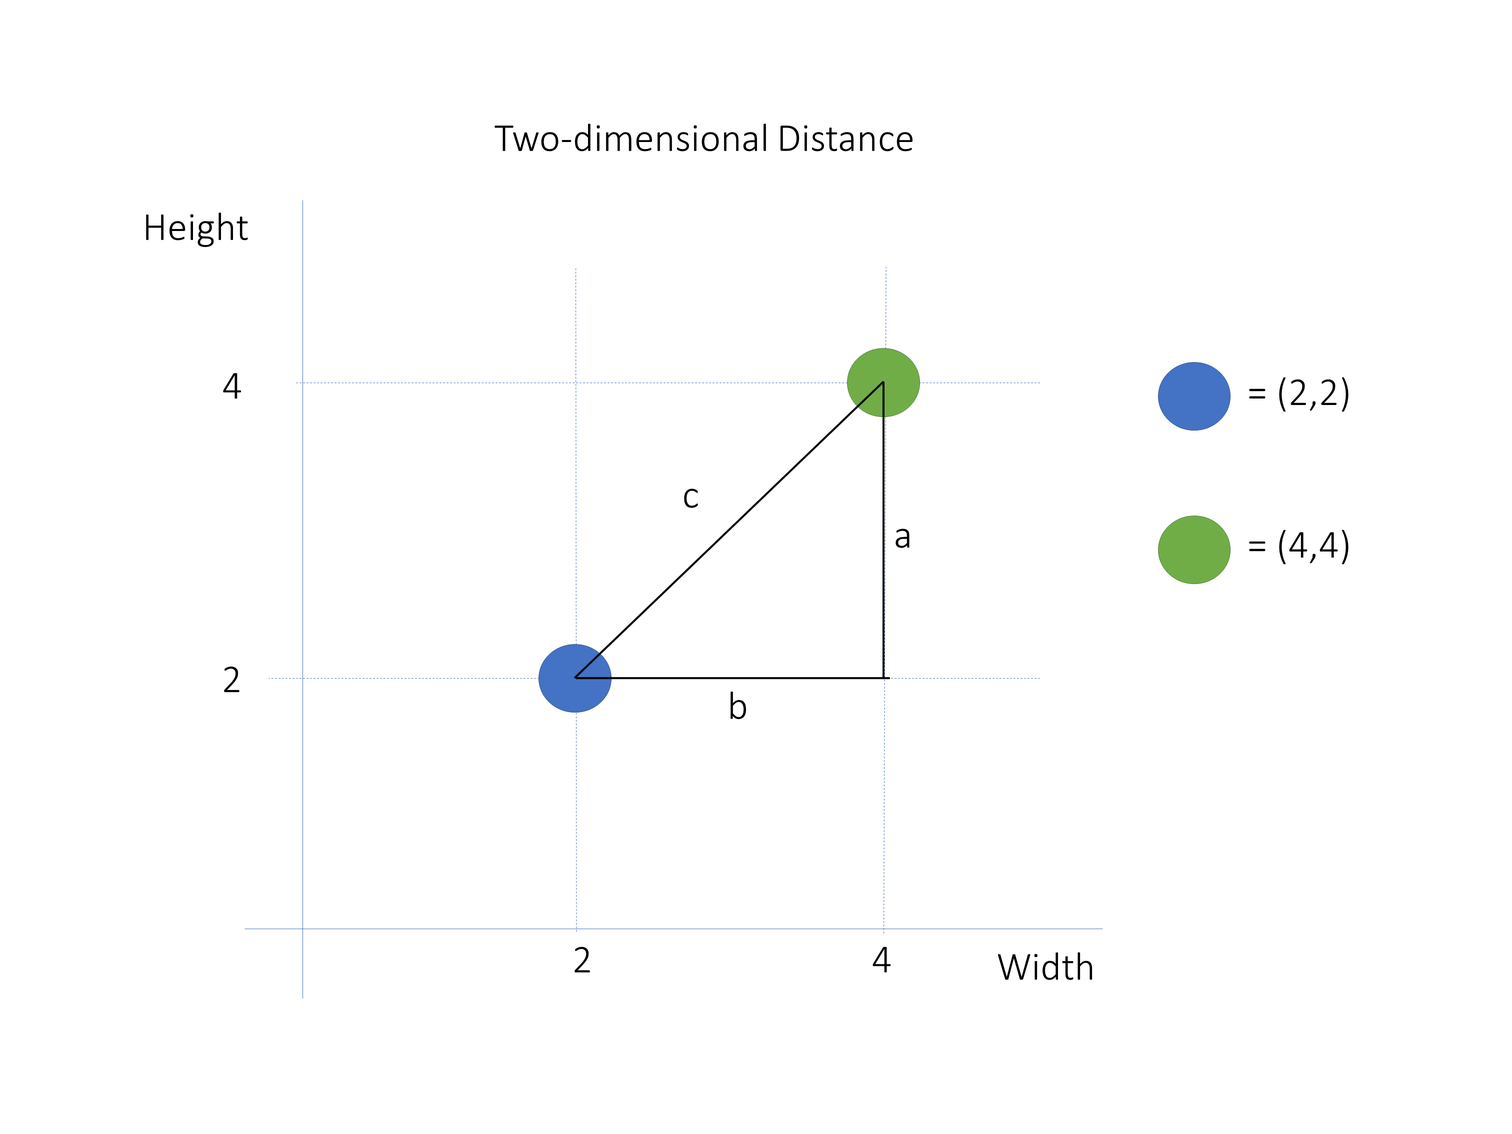

In [1]:
import numpy as np
a = np.array([2, 2])
b = np.array([4, 4])
np.linalg.norm(a - b)

2.8284271247461903

Die Distanz beträgt 2,83. Die Berechnung der Distanz stellt die Grundlage für die Anwendung des k-nearest neighbor Algorithmus, gemeinsam mit der Bestimmung der Anzahl an k Nachbarn, dar. Beobachtungen werden auf Basis der Distanz zu anderen Beobachtungen und basierend auf Mehrheitsentscheidungen klassifiziert/regressiert, bspw. kann die Zuweisung zu der Klasse, die am häufigsten unter den k Nachbarn in der gegebenen Distanz vertreten ist, erfolgen.

**Analyse Abalone Datensatz**

Der Abalone Datensatz stammt von: Sam Waugh, Department of Computer Science, University of Tasmania, Australia & Marine Resources Division, Marine Research Laboratories - Taroona, Australia

Den Original-Code findet Ihr hier: https://realpython.com/knn-python/


Verwenden wir nun die K-Nearest Neighbor Methode zur Analyse eines Datensatzes über Seeohren (große Schnecken). Dafür nutzen wir pandas, NumPy, scikit-learn und GridSearchCV. GridSearchCV ist ein Tool zur Verbesserung der Modelparameter, das auf Basis vieler Wiederholungen die beste Kombination der vorgegebenen Parameter auswählt.

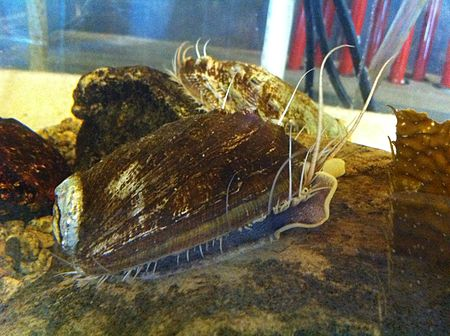

Ziel ist es, das Alter der Tiere im Datensatz vorherzusagen. Die Altersbestimmung erfolgt häufig auf Basis der Anzahl an Ringen in der Muschel. Um diese zu bestimmen, muss die Muschel jedoch aufgeschnitten werden. Im Rahmen dieser Übung erfolgt die Altersanalyse daher alternativ über physiologische Merkmale der Tiere. Da es sich beim Alter / der Anzahl der Ringe um eine metrische Variable handelt, beschäftigen wir uns nachfolgend zunächst mit einem Regressionsproblem.

Zunächst importieren wir den Datensatz mithilfe von pandas.

In [2]:
import pandas as pd
url = ( "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data")
abalone = pd.read_csv(url, header=None)

Mit der .head() Funktion verschaffen wir uns einen Überblick über den Datensatz.

In [3]:
abalone.head()

,0,1,2,3,4,5,6,7,8
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Wir stellen fest, dass noch keine Spaltennamen vorhanden sind. Diese sind unter der Dokumentation des Datensatzes zu finden (https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/) und wir fügen sie nachfolgend hinzu.

In [4]:
abalone.columns = [
     "Sex",
     "Length",
     "Diameter",
     "Height",
     "Whole weight",
     "Shucked weight",
     "Viscera weight",
     "Shell weight",
     "Rings",
 ]

Mithilfe der .head() Funktion betrachten wir erneut den Datensatz, nun ergänzt um Spaltenbezeichnungen.

In [5]:
abalone.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Anschließend betrachten wir die deskriptiven Statistiken.

In [6]:
abalone.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Die Information über das Geschlecht wird in der hier angestrebten Analyse nicht benötigt. Daher wird die dazugehörige Spalte gelöscht.

In [7]:
abalone = abalone.drop("Sex", axis=1)

Mithilfe der .head() Funktion betrachten wir erneut den Datensatz.

In [8]:
abalone.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


Zu einer vollständigen Datenanalyse gehört auch die Vorbereitung und Bereinigung von Datensätzen. Dies ist jedoch kein zentraler Bestandteil des Kurses. Der Datensatz ist bereits bereinigt, allerdings sollten wir trotzdem kurz einen Blick auf fehlende Werte werfen. Hierzu lassen wir uns die Summe der fehlenden Werte mit folgendem Code anzeigen. Hierbei bezieht sich die Funktion .isnull() auf das Dataframe und zählt die fehlenden Werte. Mit der .sum() Funktion summieren wir diese für jede Variable in unserem Dataframe:

In [9]:
abalone.isnull().sum()

Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

Mithilfe eines Histograms verschaffen wir uns einen Überblick über die Altersverteilung (Anzahl der Ringe in der Muschel).

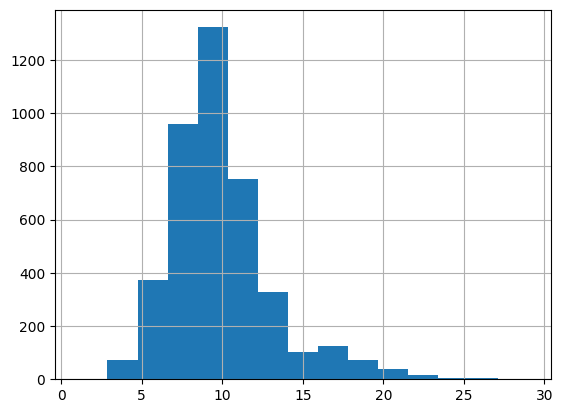

In [10]:
import matplotlib.pyplot as plt
abalone["Rings"].hist(bins=15)
plt.show()

Um auf alternative Weise das Alter vorherzusagen, ist es wichtig, die Korrelation der Anzahl an Ringen mit den weiteren Variablen im Datensatz zu prüfen und damit die Annahme zu bestätigen, dass physiologische Merkmale eine gute Möglichkeit zur Vorhersage bzw. Bestimmung des Alters sind.

In [11]:
correlation_matrix = abalone.corr()
correlation_matrix["Rings"]

Length            0.556720
Diameter          0.574660
Height            0.557467
Whole weight      0.540390
Shucked weight    0.420884
Viscera weight    0.503819
Shell weight      0.627574
Rings             1.000000
Name: Rings, dtype: float64

Je näher die Werte an 1 sind, desto höher die Korrelation (Beziehung zwischen zwei Variablen).

Im betrachteten Datensatz korrelieren die Merkmale "Gewicht der Muschel" und der "Durchmesser" am stärksten mit der Anzahl an Ringen. D.h.: Je höher das Gewicht und je größer der Durchmesser, desto größer die Anzahl der Ringe - und anders herum (Achtung: keine Kausalität). Die Koeffizienten sind jedoch nicht sehr hoch. Sehr hohe Koeffizienten lassen einen unkomplizierten Modellentwicklungsprozess erwarten. In diesem Fall könnte der Prozess etwas komplizierter bzw. das Modell mit geringerer Güte behaftet sein.

Um nun die Analyse durchführen und Abstände der Datenpunkte zueinander berechnen zu können, erstellen wir zunächst arrays und definieren x als unabhängige und y als abhängige Variable.

In [12]:
X = abalone.drop("Rings", axis=1)
X = X.values
y = abalone["Rings"]
y = y.values

Durch die Beobachtung der bisherigen Zusammenhänge der physischen Eigenschaften der Muschel können wir kNN mit bspw. 3 Nachbarn auf eine neue Beobachtung anwenden. Das heißt: Wir sagen vorher, welches Alter eine neue Muschel wahrscheinlich haben wird. Das neue Seeohr hat folgende Eigenschaften:

Variable 	           

Length 	             0.569552

Diameter 	           0.446407

Height 	             0.154437

Whole weight 	       1.016849

Shucked weight 	     0.439051

Viscera weight 	     0.222526

Shell weight 	       0.291208

Für diese neue Beobachtung erstellen wir einen NumPy array:

In [13]:
new_data_point = np.array([
     0.569552,
     0.446407,
     0.154437,
     1.016849,
     0.439051,
     0.222526,
     0.291208,
 ])

Als nächstes berechnen wir die Abstände zwischen dem neuen Datenpunkt und den bereits vorhandenen.

In [14]:
distances = np.linalg.norm(X - new_data_point, axis=1)

Nun liegt uns ein Vektor vor, der alle Abstände zwischen dem neuen und den bereits vorhandenen Datenpunkten enthält. So können wir bspw. die k=3 nächsten Nachbarn bestimmen. Mithilfe von .argsort() können wir die drei Nachbarn von am weitesten entfernt zu geringster Distanz sortieren.

In [15]:
k = 3
nearest_neighbor_ids = distances.argsort()[:k]
nearest_neighbor_ids

array([4045, 1902, 1644])

Die 3 nähesten Nachbarn weisen zwischen 9 und 11 Ringen (y) auf.

In [16]:
nearest_neighbor_rings = y[nearest_neighbor_ids]
nearest_neighbor_rings

array([ 9, 11, 10])

Um das Alter der neuen Beobachtung zu identifizieren, nutzen wir die im vorherigen Schritt bestimmten 3 nähesten Nachbarn für die Vorhersage.

In [17]:
prediction = nearest_neighbor_rings.mean()
prediction

10.0

Wir berechnen das durchschnittliche Alter bzw. die durchschnittliche Anzahl an Ringen: 10



---

**Exkurs: Klassifikationsproblem**


Nachdem wir uns mit einem Regressionsproblem auf Basis des Mittelwerts beschäftigt haben, betrachten wir nun kurz eine Klassifikation. Hierbei kommt der Modus (häufigster Wert, der in der Stichprobe vorkommt) zur Anwendung. In diesem Fall werden die Klassen der Nachbarn gezählt, um die Klasse einer Beobachtung zu bestimmen (viele gleiche Nachbarn = selbe Klasse/Kategorie wie die Nachbarn). Der neue Datenpunkt wird der Klasse, die am häufigsten vorkommt, zugeordnet.

In Python kann der Modus mit der mode() Funktion von SciPy berechnet werden. Dies schauen wir uns kurz anhand eines fiktiven Beispiels mit den Klassen "A", "B" und "C".

In [18]:
import numpy as np
from scipy import stats

class_neighbors = np.array(["A", "B", "B", "C"])

# Ermittlung der eindeutigen Elemente und ihrer Häufigkeit
values, counts = np.unique(class_neighbors, return_counts=True)

# Suche nach dem Index der häufigsten Anzahl
max_count_index = np.argmax(counts)

# Der Modus ist der Wert der höchsten Zahl
mode_value = values[max_count_index]
mode_count = counts[max_count_index]

print("Mode:", mode_value, "Count:", mode_count)

Mode: B Count: 2


Die Klasse "B" kommt am häufigsten vor. Ein neuer Datenpunkt würde damit auf Basis des Modus als "B" klassifiziert.



---


**kNN mit scikit-learn**

Nach diesem Exkurs führen wir die kNN-Analyse mithilfe von scikit-learn durch und evaluieren das Modell mit einem Train-Test-Split. Dafür importieren wir train_test_split.

Der eine Teil des Datensatzes (80%), die Trainingsdaten, werden dabei dafür verwendet, das Modell zu trainieren. Im Falle des kNN werden die Trainingsdaten als Nachbarn verwendet.

Auf Basis der Testdaten wird das Modell evaluiert. D.h. es werden Vorhersagen gemacht für die Anzahl an Ringen für jedes Seeohr im Testdatensatz. Die Vorhersagen werden dann mit der bekannten Anzahl an Ringen abgeglichen.

Mit dem random_state Parameter wird sichergestellt, dass jedes Mal, wenn der Code durchläuft, die gleichen Ergebnisse für diesen Datensatz generiert werden.


In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

Für die kNN-Analyse importieren wir KNeighborsRegressor. Die Anzahl an Nachbarn legen wir mit k=3 fest.

In [20]:
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=3)

mit .fit() wenden wir das Model auf die Trainingsdaten an.

In [21]:
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=3)



---

**Modellgüte**

Nachfolgend betrachten wir die Modellgüte. Dazu importieren wir mean_squared_error und sqrt und berechnen den mittleren quadratischen Fehler (RMSE), indem wir

1. Die Differenz zwischen dem tatsächlichen und dem vorhergesagten Wert ermitteln
2. Jede Differenz quadrieren.
3. Die quadrierten Differenzen summieren.
4. Die Wurzel aus der Summe ziehen.

Der RMSE / RMSD ist eine zentrale Metrik zur Bestimmung der Modellgüte. Er basiert auf der Differenz der Standardabweichung zwischen vorhergesagten und tatsächlichen Werten.  


In [22]:
from sklearn.metrics import mean_squared_error
from math import sqrt
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse

1.6538366794859511

Für die Trainingsdaten liegt der RMSE bei 1.65 Jahren.

Nun wenden wir das Modell und dann die Berechnung des  RMSE auf die Testdaten an.

In [23]:
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse

2.375417924000521

Der RMSE ist für die Trainingsdaten geringer als für die Testdaten. Damit verallgemeinert das Modell nicht gut, da die Differenz zwischen den Fehlerwerten relativ groß ist. Es scheint overfitting vorzuliegen: Der Algorithmus ist stark auf die Trainingsdaten angepasst und "performt" schlechter, wenn wir ihn mittels der Testdaten testen. Dies sieht man daran, dass die "Fehlerrate" (RMSE) des Algorithmus bei den Testdaten merklich höher ist als bei den Trainingsdaten.

Um die Güte zu erhöhen, werden nachfolgend die Parameter "k" und "Distanz zu den Nachbarn" angepasst. Zunächst betrachten jedoch noch einmal die Vorhersagen grafisch. Dazu nutzen wir seaborn und erstellen ein Scatterplot auf Basis von Länge und Durchmesser, den beiden ersten Spalten im Testdatensatz. Diese beiden Eigenschaften sind stark korreliert.
"c" wird verwendet, um die Vorhersagewerte als Farbpalette zu verwenden.

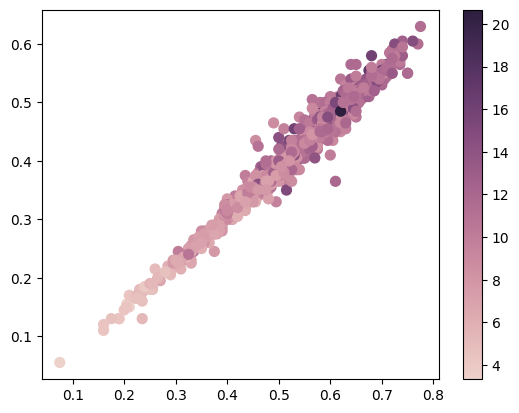

In [24]:
import seaborn as sns
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
     X_test[:, 0], X_test[:, 1], c=test_preds, s=50, cmap=cmap
 )
f.colorbar(points)
plt.show()

Jeder Datenpunkt im Scatterplot stellt eine Beobachtung aus dem Testdatensatz dar mit ihrer tatsächlichen Länge und dem Durchmesser. Die Farbe der Punkte steht für das vorhergesagte Alter.
Es ist zu erkennen, dass je länger und größer ein Seeohr ist, desto höher ist das vorhergesagte Alter.

Um zu prüfen, ob dieser Trend auch in den tatsächlichen (nicht vorhergesagten) Daten zu erkennen ist, führen wir die Visualisierung für die zu erklärende Variable im Testdatensatz durch.

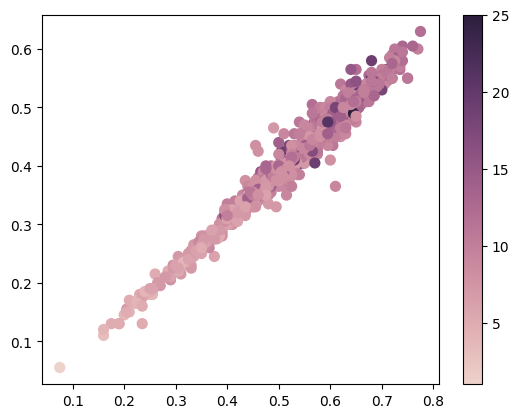

In [25]:
cmap = sns.cubehelix_palette(as_cmap=True)
f, ax = plt.subplots()
points = ax.scatter(
     X_test[:, 0], X_test[:, 1], c=y_test, s=50, cmap=cmap
 )
f.colorbar(points)
plt.show()

Auch hier ist der Trend erkennbar.



---
**Optimierung der kNN-Analyse**

Zur Verbesserung der Modellgüte verändern wir die kNN-Parameter.
Bisher hatten wir k selber festgelegt. Nun bestimmen wir es empirisch. Dafür nutzen wir GridSearchCV aus scikit-learn.

GridSearchCV führt wiederholt kNN-Analysen für unterschiedliche Parameter, wie beispielsweise unserem k, durch und prüft die Güte verschiedener Parameter. In der nachfolgenden Analyse kann k die Werte 1-50 annehmen. Das beste Ergebnis wird unter .best_params_ abgelegt.



In [26]:
from sklearn.model_selection import GridSearchCV
parameters = {"n_neighbors": range(1, 50)}
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)
GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [27]:
gridsearch.best_params_
{'n_neighbors': 25, 'weights': 'distance'}

{'n_neighbors': 25, 'weights': 'distance'}

Für k=25 wird die höchste Güte ermittelt.

Nun wenden wir das empirisch bestimmte k auf Trainings- und Testdaten an und bestimmen den Fehler 

(RMSE = Root Mean Square Error:
RMSE steht für "Root Mean Square Error" und ist ein Maß für die Genauigkeit eines Vorhersagemodells. 
Es misst den durchschnittlichen Fehler zwischen den vorhergesagten und den tatsächlichen Werten, indem es die Quadratwurzel aus dem durchschnittlichen Quadrat der Differenzen zwischen vorhergesagten und tatsächlichen Werten nimmt. 
Ein niedriger RMSE-Wert deutet auf eine höhere Genauigkeit des Modells hin.

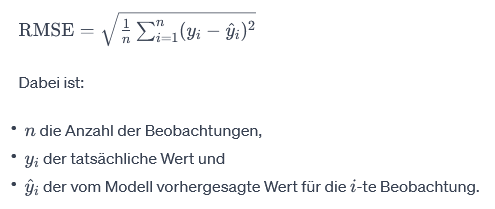

In [28]:
train_preds_grid = gridsearch.predict(X_train)
train_mse = mean_squared_error(y_train, train_preds_grid)
train_rmse = sqrt(train_mse)
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
train_rmse


2.0731180327543384

In [ ]:
test_rmse

Der Fehler für die Trainingsdaten hat sich vergrößert, während er für die Testdaten verringert wurde. Beide Werte liegen nun näher aneinander. Dies spricht für eine verbesserte Verallgemeinerbarkeit und verringertes Overfitting.

Zur weiteren Optimierung gewichteten wir den Einfluss der benachbarten Beobachtungen. Je weiter ein Nachbar entfernt, desto geringer der Einfluss auf die Vorhersage.
Da diese Veränderung das optimale k beeinflussen könnte, wenden wir erneut GridSearchCV an.

In [29]:
parameters = {
     "n_neighbors": range(1, 50),
     "weights": ["uniform", "distance"],
 }
gridsearch = GridSearchCV(KNeighborsRegressor(), parameters)
gridsearch.fit(X_train, y_train)

GridSearchCV(estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': range(1, 50),
                         'weights': ['uniform', 'distance']})

In [30]:
gridsearch.best_params_

{'n_neighbors': 25, 'weights': 'distance'}

Die optimale Anzahl an Nachbarn k liegt wiederum bei 25.

In [31]:
test_preds_grid = gridsearch.predict(X_test)
test_mse = mean_squared_error(y_test, test_preds_grid)
test_rmse = sqrt(test_mse)
test_rmse

2.1634265584947485

Der Fehler für die Testdaten ist etwas verringert worden und liegt nun bei 2.16.

Zur weiteren Verbesserung des Ergebnisses könnten noch andere Verfahren wie zum Beispiel "bagging" angewendet werden. Darauf wird in Sitzung 11 weiter eingegangen.